In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import draw
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, closing, disk
from skimage.segmentation import find_boundaries
from skimage.transform import resize
from skimage.util import img_as_ubyte
from sklearn.metrics import roc_auc_score
%matplotlib inline

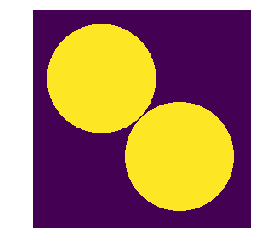

In [2]:
x = np.zeros((256, 256))
cy, cx = 80, 80
radius = 64
cy2 = cx2 = (np.sqrt(cy **2 + cx **2) + 2 * radius) * np.cos(np.pi / 4) + 1
o1r, o1c = draw.circle(cy, cx, radius)
o2r, o2c = draw.circle(cy2, cx2, radius)
x[o1r, o1c] = 1
x[o2r, o2c] = 1
plt.imshow(x)
_ = plt.axis('off')

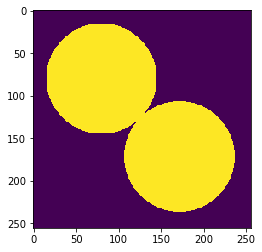

In [3]:
plt.imshow(binary_dilation(x))

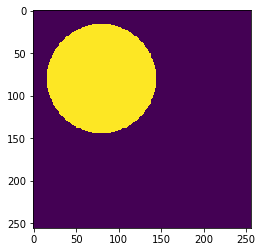

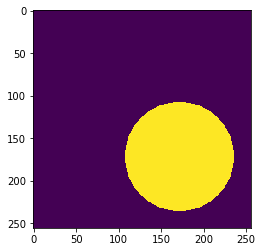

In [4]:
xlabel = label(x)
regions = regionprops(xlabel)
ground_truth_masks = []
for region in regions:
    rrows, rcols = zip(region.coords.T)
    X = np.zeros((256, 256))
    X[rrows, rcols] = 1
    ground_truth_masks.append(X)
    plt.figure()
    plt.imshow(X)
ground_truth_masks = np.array(ground_truth_masks)

In [5]:
predicted_mask = np.array([binary_dilation(x)])

In [6]:
y_true = ground_truth_masks.sum(0)
y_pred = predicted_mask.sum(0)

In [7]:
roc_auc_score(y_true.ravel(), y_pred.ravel())

0.9908531222515392

# IOU

In [8]:
THRESHOLDS = np.arange(0.5, 1, 0.05).reshape(10, 1, 1)

In [9]:
def iou(masks_true, masks_pred):
    """
    Get the IOU between each predicted mask and each true mask.

    Parameters
    ----------------

    masks_true : vartype
        masks_true is
    masks_pred : vartype
        masks_pred is

    Returns
    ----------------

    """
    if masks_true.shape[1:] != masks_pred.shape[1:]:
        raise ValueError('Predicted masks have wrong shape!')
    n_true_masks, height, width = masks_true.shape
    n_pred_masks = masks_pred.shape[0]
    m_true = masks_true.copy().reshape(n_true_masks, height * width).T
    m_pred = masks_pred.copy().reshape(n_pred_masks, height * width)
    numerator = np.dot(m_pred, m_true)
    denominator = m_pred.sum(1).reshape(-1, 1) + m_true.sum(0).reshape(1, -1)
    return numerator / (denominator - numerator)

def evaluate_image(masks_true, masks_pred):
    """
    Get the MAP for the true and predicted masks of a single image.

    Parameters
    ----------------

    masks_true : vartype
        masks_true is
    masks_pred : vartype
        masks_pred is

    Returns
    ----------------

    """
    int_o_un = iou(masks_true, masks_pred)
    benched = int_o_un > THRESHOLDS
    tp = benched.sum(-1).sum(-1)  # noqa
    fp = (benched.sum(2) == 0).sum(1)
    fn = (benched.sum(1) == 0).sum(1)
    return np.mean(tp / (tp + fp + fn))

In [10]:
evaluate_image(ground_truth_masks, predicted_mask)

0.0

In [11]:
iou(ground_truth_masks, predicted_mask)

array([[0.48543579, 0.48706033]])

# New predictions

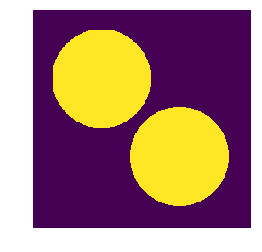

In [12]:
xnew = np.zeros((256, 256))
cy, cx = 80, 80
radiusn = 58
cy2 = cx2 = (np.sqrt(cy **2 + cx **2) + 2 * 64) * np.cos(np.pi / 4) + 1
o1r, o1c = draw.circle(cy, cx, radiusn)
o2r, o2c = draw.circle(cy2, cx2, radiusn)
xnew[o1r, o1c] = 1
xnew[o2r, o2c] = 1
plt.imshow(xnew)
_ = plt.axis('off')

In [13]:
xlabelnew = label(xnew)
regions = regionprops(xlabelnew)
predicted_masks_new = []
for region in regions:
    rrows, rcols = zip(region.coords.T)
    X = np.zeros((256, 256))
    X[rrows, rcols] = 1
    predicted_masks_new.append(X)

In [14]:
y_pred_new = np.array(predicted_masks_new)
y_pred_new = y_pred_new.sum(0)

In [15]:
roc_auc_score(y_true.ravel(), y_pred_new.ravel())

0.9102598966629113

In [16]:
masks_pred_new = np.array(predicted_masks_new)

In [17]:
evaluate_image(ground_truth_masks, masks_pred_new)

0.7

In [18]:
# conclusion: segmentation errors are penalized a lot more than pixelwise loss,
# pixelwise accuracy is rewarded a lot less than correct segmentation

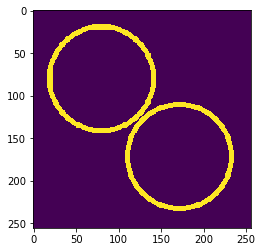

In [19]:
plt.imshow(np.abs(y_true - y_pred_new))

# Understanding the metric:

|$p_{1}$|$p_{2}$|$p_{3}$|$…$|$p_{l}$
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
$a_{1}$|$O_{11}$|$O_{12}$|$O_{13}$|$…$|$O_{1l}$
$a_{2}$|$O_{21}$|$O_{22}$|$O_{23}$|$…$|$O_{2l}$
$a_{3}$|$O_{31}$|$O_{32}$|$O_{33}$|$…$|$O_{3l}$
…|…|…|…|…|…
$a_k$|$O_{k1}$|$O_{k2}$|$O_{k3}$|$…$|$O_{kl}$


/Users/jaidevd/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/Users/jaidevd/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


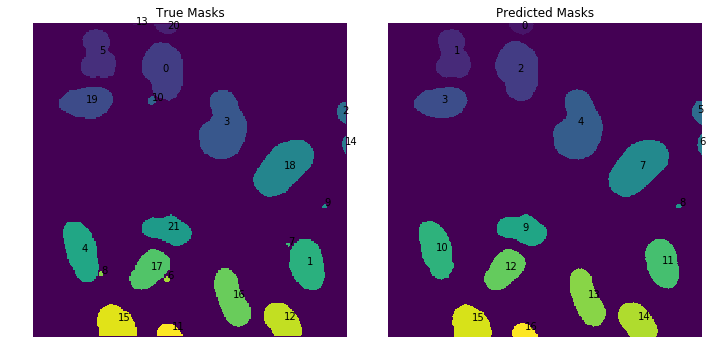

In [20]:
def unsupervised_regions(image, threshold, blocksize):
    image = img_as_ubyte(image)
    masks = []
    thresh = threshold(image, blocksize)
    bw = closing(image > thresh, disk(5))
    labeled = label(bw)
    regions = regionprops(labeled)
    for region in regions:
        mask = np.zeros(image.shape)
        minr, minc, maxr, maxc = region.bbox
        mask[minr:maxr, minc:maxc] = region.image.astype(int)
        masks.append(mask)
    return np.array(masks)


def inverse_rle(x, imsize):
    mask = np.zeros(imsize, dtype=bool).ravel(order='F')
    for startix, length in zip(x[::2], x[1::2]):
        mask[(startix - 1):(startix - 1 + length)] = True
    return mask.reshape(imsize, order='F')


# IDEAL_IMAGEID = '2a2032c4ed78f3fc64de7e5efd0bec26a81680b07404eaa54a1744b7ab3f8365'
ORIGINAL_SIZE = 360, 360
x = imread('images/iou-example.jpg', as_grey=True)

predicted_masks = unsupervised_regions(x, threshold_otsu, 3)
predicted_masks = predicted_masks.astype(int)
labeled = label(predicted_masks.sum(0))

act_masks = []
with open('data/iou-mask-rle.txt', 'r') as fin:
    rle_masks = fin.readlines()
for mask in rle_masks:
    maskarray = inverse_rle(list(map(int, mask.rstrip().split())), ORIGINAL_SIZE)
    act_masks.append(maskarray)
act_masks = np.array(act_masks)
act_masks = resize(act_masks.T, x.shape[::-1], preserve_range=True).T.astype(int)
y_label = label(act_masks.sum(0))

act_centers = []
predicted_centers = []
for mask in act_masks:
    r = regionprops(mask)[0]
    rmin, cmin, rmax, cmax = r.bbox
    rc = (rmin + rmax) / 2
    cc = (cmin + cmax) / 2
    act_centers.append((rc, cc))

for mask in predicted_masks:
    r = regionprops(mask)[0]
    rmin, cmin, rmax, cmax = r.bbox
    rc = (rmin + rmax) / 2
    cc = (cmin + cmax) / 2
    predicted_centers.append((rc, cc))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))
ax1, ax2 = ax
ax1.set_axis_off()
ax2.set_axis_off()
ax1.imshow(y_label)
ax2.imshow(labeled)

for i, c in enumerate(act_centers):
    ax1.annotate(str(i), xy=c[::-1])

for i, c in enumerate(predicted_centers):
    ax2.annotate(str(i), xy=c[::-1])

ax1.set_title('True Masks')
ax2.set_title('Predicted Masks')
fig.tight_layout()

In [21]:
predicted_masks.shape

(17, 512, 512)

In [22]:
act_masks.shape

(22, 512, 512)

In [23]:
ious = np.zeros((22, 17))

In [24]:
for ai in range(22):
    for pi in range(17):
        amask = act_masks[ai].ravel()
        pmask = predicted_masks[pi].ravel()
        intersection = np.dot(amask, pmask)
        union = amask.sum() + pmask.sum() - intersection
        ious[ai, pi] = intersection / union

In [25]:
vector_intersection = vector_union = np.zeros((22, 17))

In [26]:
ORGSIZE = x.shape[0] * x.shape[1]

In [27]:
predicted_masks.shape

(17, 512, 512)

In [28]:
act_masks.shape

(22, 512, 512)

In [29]:
vector_intersection = np.dot(act_masks.reshape(22, ORGSIZE), predicted_masks.reshape(17, ORGSIZE).T)

In [30]:
vector_union = act_masks.reshape(22, ORGSIZE).sum(1, keepdims=True) + \
               predicted_masks.reshape(17, ORGSIZE).T.sum(0, keepdims=True) - \
               vector_intersection

In [31]:
vec_iou = vector_intersection / vector_union

In [32]:
np.allclose(vec_iou, ious)

True

In [33]:
thresholded_iou = vec_iou > THRESHOLDS

In [34]:
thresholded_iou.shape

(10, 22, 17)

In [35]:
THRESHOLDS = THRESHOLDS.reshape(10, 1, 1)

# Mean Precision
$$ \cfrac{1}{|\theta|}\sum_{k \in \theta}\cfrac{t_{p}(k)}{t_{p}(k) + f_{p}(k) + f_{n}(k)}$$

Where 

* $ \theta $ is set of thresholds,
* $t_{p}(k)$ is the number of true positives at threshold $k$ - the number of predicted objects matching a ground truth object,
* $f_{p}(k)$ is the number of false positives at threshold $k$ - the number of predicted objects matching no ground truth objects,
* $f_{n}(k)$ is the number of false negatives at threshold $k$ - the number of ground truth objects matching no prediction,

In [36]:
tp = (thresholded_iou.sum(1) > 0).sum(1)

In [37]:
fp = (thresholded_iou.sum(1) == 0).sum(1)

In [38]:
fn = (thresholded_iou.sum(2) == 0).sum(1) 

In [39]:
MAP = np.mean(tp / (tp + fp + fn))

In [40]:
MAP

0.6380311264822135

In [41]:
evaluate_image(act_masks, predicted_masks)

0.6380311264822135

# The model
![](images/unet.png)

# Weighing the Cross Entropy Loss
The output layer produces a volume of size $height \times width \times K$, where $K$ is the number of classes. In this case, $K = 2$
Thus, the softmax activation for each channel (channel here corresponds to target class, not color channels) $k \in [1, K]$ is:

$$ p_{k}(\mathbf{x}) = \cfrac{exp(a_{k}(\mathbf{x}))}{\sum_{k'=1}^{K}exp(a_{k'}(\mathbf{x}))}$$,

where $a(\mathbf{x})$ is the unactivated output of the last layer.
Then, the cross entropy loss is,

$$E = \sum w(\mathbf{x})log(p_{l(\mathbf{x)}}(\mathbf{x}))$$

where $l(\mathbf{x})$ is the true label of each pixel and $w(\mathbf{x})$ are pixelwise weights to prioritize certain pixels over others [1].

$w$ is calculated as:

$$ w(\mathbf{x}) = w_{c}(\mathbf{x}) + w_{0} \times exp \Biggl( -\frac{(d_{1}(\mathbf{x}) + d_{2}(\mathbf{x}))^2}{2\sigma^2} \Biggr)$$

where
* $w_{c}$ is the weight map to balance pixel classes.
* $d_{1}$ is the distance to the border of the nearest cell,
* $d_{2}$ is the distance to the border of the second nearest cell.

In [42]:
w0 = 10
sigma = 5

def process_mask(masks):
    nrows, ncols = masks.shape[1:]
    masks = (masks > 0).astype(int)
    distMap = np.zeros((nrows * ncols, masks.shape[0]))
    X1, Y1 = np.meshgrid(np.arange(nrows), np.arange(ncols))
    X1, Y1 = np.c_[X1.ravel(), Y1.ravel()].T
    for i, mask in enumerate(masks):
        bounds = find_boundaries(mask, mode='inner')
        X2, Y2 = np.nonzero(bounds)
        xSum = (X2.reshape(-1, 1) - X1.reshape(1, -1)) ** 2
        ySum = (Y2.reshape(-1, 1) - Y1.reshape(1, -1)) ** 2
        distMap[:, i] = np.sqrt(xSum + ySum).min(axis=0)
    ix = np.arange(distMap.shape[0])
    if distMap.shape[1] == 1:
        d1 = distMap.ravel()
        border_loss_map = w0 * np.exp((-1 * (d1) ** 2) / (2 * (sigma ** 2)))
    else:
        if distMap.shape[1] == 2:
            d1_ix, d2_ix = np.argpartition(distMap, 1, axis=1)[:, :2].T
        else:
            d1_ix, d2_ix = np.argpartition(distMap, 2, axis=1)[:, :2].T
        d1 = distMap[ix, d1_ix]
        d2 = distMap[ix, d2_ix]
        border_loss_map = w0 * np.exp((-1 * (d1 + d2) ** 2) / (2 * (sigma ** 2)))
    xBLoss = np.zeros((nrows, ncols))
    xBLoss[X1, Y1] = border_loss_map
    # class weight map
    loss = np.zeros((nrows, ncols))
    w_1 = 1 - masks.sum() / loss.size
    w_0 = 1 - w_1
    loss[masks.sum(0) == 1] = w_1
    loss[masks.sum(0) == 0] = w_0
    ZZ = xBLoss + loss
    # ZZ = resize(ZZ, (512, 512), preserve_range=True)
    return ZZ

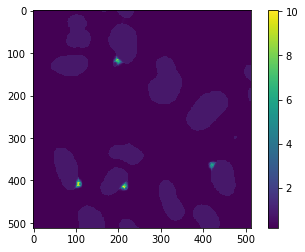

In [43]:
wmask = process_mask(act_masks)
plt.imshow(wmask)
plt.colorbar()

# References
<ol>
<li>
Olaf Ronneberger, Philipp Fischer: “U-Net: Convolutional Networks for Biomedical Image Segmentation”, 2015; <a href='http://arxiv.org/abs/1505.04597'>arXiv:1505.04597</a>.
</li>
</ol>